## stackSentinel.py Overview

`stackSentinel.py` is a key script in the ISCE processing chain, designed to automate the preprocessing of Sentinel-1 SAR data. It orchestrates various steps from initial data unpacking to generating interferograms, coherence maps, and applying necessary filters. Below is an overview of its workflow:

### 1. Data Input and Unpacking
The script begins by organizing and unpacking Sentinel-1 SAR data. It sets up directories and prepares the raw SAR data for further processing. This typically involves downloading and unpacking the raw Sentinel-1 products.

### 2. Interferogram Calculation
After unpacking, `stackSentinel.py` facilitates the calculation of interferograms between pairs of SAR images. These interferograms are the basis for detecting ground displacement.

### 3. Coherence Map Generation
The script generates coherence maps that quantify the correlation between SAR image pairs. High coherence values indicate stable surfaces, while low coherence values suggest changes or noisy areas.

### 4. Phase Unwrapping and Topographic Phase Removal
To process the interferograms, the script performs phase unwrapping, eliminating ambiguities in phase values. It also removes the topographic phase component, isolating the deformation signal from the topographic effects.

### 5. Filtering and Refining
Several filtering steps are included in the script to remove noise from the interferograms and coherence maps. This step enhances the quality of the data by smoothing and reducing phase errors.

### 6. Coherence Thresholding and Final Filtering
The script applies a coherence threshold, removing low-coherence regions, and further refines the coherence map by filtering out any remaining noise.

### 7. Output: `filt_fine.cor`
The final output of the script is a filtered and processed coherence map, stored in the `/merged/interferograms/` directory. This file, `filt_fine.cor`, serves as the foundation for any subsequent analysis of surface displacements or deformations.

### Purpose
The main purpose of `stackSentinel.py` is to automate the preprocessing steps for Sentinel-1 data, ensuring that the generated interferograms and coherence maps are of high quality and suitable for further analysis.




---

# InSAR Data Processing Utilities

This script provides several utilities to work with InSAR data, specifically focusing on geospatial transformations, file reading and writing, and data processing. It contains functions for converting geographic bounding boxes into SAR row/column indices, reading ISCE2 formatted files, and writing output data back to various file formats, including ISCE2 and GDAL. These utilities are particularly useful for processing and manipulating interferogram data from InSAR missions.

## Functions

### 1. `bbox2SAR(lat_min, lat_max, lon_min, lon_max, lat_data, lon_data)`

Converts a geographic bounding box (latitude and longitude) into SAR (Synthetic Aperture Radar) row and column indices in the azimuth and range directions.

* **Arguments**:

  * `lat_min`: Minimum latitude.
  * `lat_max`: Maximum latitude.
  * `lon_min`: Minimum longitude.
  * `lon_max`: Maximum longitude.
  * `lat_data`: A 2D array of latitude values for the SAR grid.
  * `lon_data`: A 2D array of longitude values for the SAR grid.
* **Returns**:

  * A list containing the SAR region in terms of row and column indices that correspond to the geographic bounding box.

### 2. `read_isce_file(file)`

Reads an ISCE2 formatted file (commonly used in InSAR data) and returns it as a NumPy array.

* **Arguments**:

  * `file`: Path to the ISCE2 formatted file (e.g., `.unw` file).
* **Returns**:

  * A NumPy array representing the data in the ISCE2 file.

### 3. `write_gdal_file(arr, output_filepath, data_type=gdal.GDT_Float32)`

Writes a NumPy array to a file using GDAL, specifically in the ENVI format. This function handles both 2D and 3D arrays.

* **Arguments**:

  * `arr`: The NumPy array to write to the file.
  * `output_filepath`: The path to the output file.
  * `data_type`: The data type for the output file (default is `gdal.GDT_Float32`).
* **Returns**:

  * None. The function writes the array to the specified file.

### 4. `write_arr2file(arr, output_filepath)`

Writes a NumPy array to an ISCE2 formatted file (such as `.unw`, `.cor`, or `.rdr`).

* **Arguments**:

  * `arr`: The NumPy array to convert and write.
  * `output_filepath`: The path to the output ISCE2 file.
* **Returns**:

  * None. The function writes the array to the specified ISCE2 file.


In [1]:
   
from mintpy.utils.writefile import * 
from osgeo import gdal  
import os, sys
import numpy as np
import math
import geopandas as gpd
from shapely.geometry import Polygon


## geobbox to SAR row/col in the azimuth&range direction 
def bbox2SAR(lat_min, lat_max, lon_min, lon_max, lat_data, lon_data):
    #  convert geographic bounding box to SAR ROI indicies. (azimuth and range)
    # <1> lat_min (float)     : minimum latitude
    # <2> lat_max (float)     : maximum latitude
    # <3> lon_min (float)     : minimum longitude
    # <4> lon_max (float)     : maximum longitude
    # <5> lat_data (np.array) : the latitude lookuptable lat.rdr  
    # <6> lon_data (np.array) : the lontitude lookuptable lon.rdr
    # <return> region_rec: return the SAR row col list 
    S, N, W, E = lat_min, lat_max, lon_min, lon_max
    geo_coord = [W, N, E, S]
    data_map =  (lon_data >= geo_coord[0])*(lon_data <= geo_coord[2])*(lat_data>=geo_coord[3])*(lat_data<=geo_coord[1])
    region_list = np.argwhere(data_map==1)
    region_rec = [10*math.floor(region_list[:,0].min()/10),10*math.ceil(region_list[:,0].max()/10),\
              10*math.floor(region_list[:,1].min()/10),10*math.ceil(region_list[:,1].max()/10)]
    return region_rec
    
## convert ISCE2 formatted file to npArray
def read_isce_file(file):
    # convert a GDAL_realiable file (usually ISCE2 file) to a numpy array 
    # <1> file(str): a string-path of input file 
    _, ext = os.path.splitext(file)
    ds = gdal.Open(file,gdal.GA_ReadOnly)
    print("input dataset BandsCount : ", ds.RasterCount)
    ## get the phase band for the unw data
    if ext != ".unw":band = ds.GetRasterBand(1)
    else:band = band = ds.GetRasterBand(2)
    data = np.expand_dims(band.ReadAsArray(), 2)
    W, L, N = data.shape
    loader = np.zeros([W, L, N], dtype=np.float32)
    loader[:,:,0] = data[:,:,0]
    return loader


## there may be some problems in the funtion @
## don`t use it 
def write_gdal_file(arr, output_filepath, data_type=gdal.GDT_Float32):
    if len(arr.shape) == 2:
        rows, cols = arr.shape
        bands = 1
        data_to_write = arr
    elif len(arr.shape) == 3:
        rows, cols, bands = arr.shape
        data_to_write = arr[:, :, 0] if bands == 1 else arr
    else:
        raise ValueError("Array must be 2D or 3D")
    driver = gdal.GetDriverByName('ENVI')    
    dataset = driver.Create(output_filepath, cols, rows, 1, data_type)
    if dataset is None:
        raise RuntimeError(f"Could not create file: {output_filepath}")
    if len(arr.shape) == 2:
        dataset.GetRasterBand(1).WriteArray(data_to_write)
    else:
        dataset.GetRasterBand(1).WriteArray(data_to_write[:, :])
    dataset.FlushCache()
    dataset = None
    print(f"GDAL write {output_filepath} finished")


## write np.array to the ISCE2 file according to the input array
def write_arr2file(arr, output_filepath):
    ## write np.array to the ISCE2 file according to the input array
    ## <1> arr(numpy.array) : the numpy array to convert
    ## <2> out_path (str)   : the output path of the arr2ISCEfile
    mirror_dic = {
        ".unw": "MOD_isce_unw", 
        ".cor": "isce_cor", 
        ".rdr": "isce_cor", 
        ".int": "isce_int",
        ".full": "envi"
    }
    _, ext = os.path.splitext(output_filepath)
    if ext == ".full":
        write_gdal_file(arr, output_filepath)
        return
    if ext not in mirror_dic:
        raise ValueError(f"Unsupported file extension: {ext}")
    file_type = mirror_dic[ext]
    write_isce_file(
        data = arr[:,:,0],
        out_file = output_filepath ,
        file_type = file_type
    )
    print(f"write {output_filepath} finished ")

# Batch Crop of `filt_fine.cor` Files for InSAR Data

This script provides a utility to batch crop `filt_fine.cor` files along with the corresponding latitude (`lat.rdr`) and longitude (`lon.rdr`) files from an InSAR dataset. The cropping is done based on a specified geographic region (latitude and longitude bounds), which is then converted into SAR image coordinates. The output files, which include the cropped versions of the `filt_fine.cor`, latitude, and longitude files, are saved to the designated output directory.

## Key Functions

1. **`batch_crop_filt_fine_cor()`**:

   * This function processes all `filt_fine.cor` files in a given directory, crops them according to the specified geographic bounds, and saves the cropped files.
   * It also crops the corresponding latitude and longitude files from the geometry reference path.

2. **`crop_single_band_file()`**:

   * Crops a single band file (such as a `filt_fine.cor` file) based on the provided coordinates and saves the cropped data.
   * It checks whether the cropping region exceeds the data boundaries and adjusts accordingly.

3. **`read_isce_file()`** and **`write_arr2file()`**:

   * These helper functions are used for reading ISCE-formatted files and writing arrays to the corresponding output files (e.g., `.rdr`, `.cor`).

## Script Overview

* **Input**:

  * A directory containing `filt_fine.cor` files (`base_path`).
  * A reference geometry path containing `lat.rdr` and `lon.rdr` files (`geom_reference_path`).
* **Output**:

  * Cropped versions of the `filt_fine.cor`, latitude (`lat.rdr`), and longitude (`lon.rdr`) files saved to a specified output directory (`output_base_path`).

### Geographic Region for Cropping

The script is set to crop the data based on a fixed geographic bounding box:

* **Latitude**: [42.625, 42.635]
* **Longitude**: [13.28, 13.30]

These bounds are used to define the region to be extracted from the InSAR dataset.

## Example Workflow

1. **Input Data**:

   * `filt_fine.cor` files for interferogram data.
   * `lat.rdr` and `lon.rdr` files for the corresponding latitude and longitude grids.

2. **Cropping**:

   * The latitude and longitude data are used to find the SAR region corresponding to the geographic bounding box.
   * Each `filt_fine.cor` file is then cropped based on this region.

3. **Output**:

   * The cropped files are saved in the specified output directory.



In [2]:
import os
import numpy as np
from osgeo import gdal
import traceback
import re


def batch_crop_filt_fine_cor(base_path, geom_reference_path, output_base_path):
    """
    Batch crop all filt_fine.cor files and simultaneously crop corresponding lat and lon files.
    
    Parameters:
    base_path: The base path containing filt_fine.cor files
    geom_reference_path: The geometry reference path containing lat and lon files
    output_base_path: The base path where cropped files will be saved
    """
    
    # Use the provided latitude and longitude range
    lat_min, lat_max = 42.625, 42.635
    lon_min, lon_max = 13.28, 13.30
    
    print(f"Using cropping region: Latitude[{lat_min}, {lat_max}], Longitude[{lon_min}, {lon_max}]")
    
    # Look for lat and lon files
    lat_file = os.path.join(geom_reference_path, "lat.rdr")
    lon_file = os.path.join(geom_reference_path, "lon.rdr")
    
    if not os.path.exists(lat_file):
        # Try other possible file names
        lat_files = [f for f in os.listdir(geom_reference_path) if "lat" in f.lower() and not f.startswith('.')]
        if lat_files:
            lat_file = os.path.join(geom_reference_path, lat_files[0])
            print(f"Using found latitude file: {lat_file}")
        else:
            print(f"Error: Could not find lat file in {geom_reference_path}")
            return
    
    if not os.path.exists(lon_file):
        # Try other possible file names
        lon_files = [f for f in os.listdir(geom_reference_path) if "lon" in f.lower() and not f.startswith('.')]
        if lon_files:
            lon_file = os.path.join(geom_reference_path, lon_files[0])
            print(f"Using found longitude file: {lon_file}")
        else:
            print(f"Error: Could not find lon file in {geom_reference_path}")
            return
    
    print(f"Using lat file: {lat_file}")
    print(f"Using lon file: {lon_file}")
    
    # Read lat and lon data
    lat_data = read_isce_file(lat_file)
    lon_data = read_isce_file(lon_file)
    print(f"Lat file shape: {lat_data.shape}")
    print(f"Lon file shape: {lon_data.shape}")
    
    # Calculate the cropping region (SAR coordinates)
    region_rec = bbox2SAR(lat_min, lat_max, lon_min, lon_max, lat_data, lon_data)
    if len(region_rec) != 4:
        print("Invalid region coordinates")
        return
    
    y_min, y_max, x_min, x_max = region_rec
    height = y_max - y_min
    width = x_max - x_min
    print(f"Geographical coordinates converted to SAR coordinates: [{y_min}, {y_max}, {x_min}, {x_max}]")
    print(f"SAR image range: Rows {y_min} to {y_max}, Columns {x_min} to {x_max}")
    print(f"SAR image size: {height} × {width} (Height × Width)")
    
    # Check if the cropping region is valid
    if height <= 0 or width <= 0:
        print("Error: Invalid cropping region, height or width is 0")
        return
    
    # Crop the lat and lon files
    lat_cropped = lat_data[y_min:y_max, x_min:x_max]
    lon_cropped = lon_data[y_min:y_max, x_min:x_max]
    
    # Save the cropped lat and lon files
    lat_output = os.path.join(output_base_path, "lat_cropped.rdr")
    lon_output = os.path.join(output_base_path, "lon_cropped.rdr")
    
    write_arr2file(lat_cropped, lat_output)
    write_arr2file(lon_cropped, lon_output)
    
    print(f"Cropped lat file saved: {lat_output}, shape: {lat_cropped.shape}")
    print(f"Cropped lon file saved: {lon_output}, shape: {lon_cropped.shape}")
    
    # Walk through the directory structure and find filt_fine.cor files
    cor_files = []
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file == "filt_fine.cor":
                cor_files.append(os.path.join(root, file))
    
    print(f"Found {len(cor_files)} filt_fine.cor files")
    
    # Process each file
    for i, cor_file in enumerate(cor_files):
        print(f"\nProcessing file {i+1}/{len(cor_files)}: {cor_file}")
        
        try:
            # Extract date information from file path
            # Assuming the path format is: .../YYYYMMDD_YYYYMMDD/filt_fine.cor
            date_match = re.search(r'(\d{8}_\d{8})', cor_file)
            if date_match:
                date_str = date_match.group(1)
                print(f"Extracted date information: {date_str}")
            else:
                # If no date is found, use the parent directory name
                parent_dir = os.path.basename(os.path.dirname(cor_file))
                date_str = parent_dir
                print(f"Using parent directory name as date: {date_str}")
            
            # Create the output file name
            output_file = os.path.join(output_base_path, f"{date_str}_filt_fine.cor")
            
            # Check if the output file already exists
            if os.path.exists(output_file):
                print(f"Skipping existing file: {output_file}")
                continue
            
            # Call the cropping function
            crop_single_band_file(
                cor_file, y_min, y_max, x_min, x_max, output_file
            )
            
            print(f"Successfully cropped: {output_file}")
            
        except Exception as e:
            print(f"Error processing file {cor_file}: {str(e)}")
            traceback.print_exc()

def crop_single_band_file(file, y_min, y_max, x_min, x_max, out_file):
    """Crop a single band file (such as filt_fine.cor)"""
    
    # Read data
    data = read_isce_file(file)
    print(f"Original data shape: {data.shape}")
    
    # Check if the cropping region exceeds data boundaries
    data_height, data_width = data.shape[0], data.shape[1]
    if y_max > data_height or x_max > data_width:
        print(f"Warning: Cropping region exceeds data boundaries, adjusting cropping region")
        y_max = min(y_max, data_height)
        x_max = min(x_max, data_width)
        print(f"Adjusted SAR coordinates: [{y_min}, {y_max}, {x_min}, {x_max}]")
    
    # Crop data
    if len(data.shape) == 2:  # Single band data
        data_crop = data[y_min:y_max, x_min:x_max]
    elif len(data.shape) == 3:  # Multi-band data
        data_crop = data[y_min:y_max, x_min:x_max, :]
    else:
        print(f"Unsupported data dimensions: {len(data.shape)}")
        return
    
    print(f"Cropped data shape: {data_crop.shape}")
    
    # Calculate data statistics
    if np.iscomplexobj(data_crop):
        print(f"Complex data range: Min magnitude={np.min(np.abs(data_crop)):.4f}, Max magnitude={np.max(np.abs(data_crop)):.4f}")
    else:
        print(f"Data range: Min={np.min(data_crop):.4f}, Max={np.max(data_crop):.4f}")
    
    # Save cropped data
    if not file.endswith("full"):
        write_arr2file(data_crop, out_file)
    else:
        write_gdal_file(data_crop, out_file)

def main():
    """Main function"""
    
    # Set path parameters
    base_path = "/data6/WORKDIR/AmatriceSenDT22/merged/interferograms"
    geom_reference_path = "/data6/WORKDIR/AmatriceSenDT22/merged/geom_reference"
    output_base_path = "/data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped"  # Output directory
    
    # Ensure the output directory exists
    os.makedirs(output_base_path, exist_ok=True)
    
    print("Starting batch crop of filt_fine.cor files")
    print(f"Input path: {base_path}")
    print(f"Geometry reference path: {geom_reference_path}")
    print(f"Output path: {output_base_path}")
    
    # Execute batch cropping
    batch_crop_filt_fine_cor(
        base_path, geom_reference_path, output_base_path
    )
    
    print("\nBatch cropping complete!")

if __name__ == '__main__':
    main()


Starting batch crop of filt_fine.cor files
Input path: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms
Geometry reference path: /data6/WORKDIR/AmatriceSenDT22/merged/geom_reference
Output path: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped
Using cropping region: Latitude[42.625, 42.635], Longitude[13.28, 13.3]
Using lat file: /data6/WORKDIR/AmatriceSenDT22/merged/geom_reference/lat.rdr
Using lon file: /data6/WORKDIR/AmatriceSenDT22/merged/geom_reference/lon.rdr
input dataset BandsCount :  1
input dataset BandsCount :  1
Lat file shape: (2858, 26031, 1)
Lon file shape: (2858, 26031, 1)
Geographical coordinates converted to SAR coordinates: [950, 1060, 21330, 21870]
SAR image range: Rows 950 to 1060, Columns 21330 to 21870
SAR image size: 110 × 540 (Height × Width)
write file: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/lat_cropped.rdr
write file: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/lat_cropped.rdr.xml
write file: /data6/WORKD

# InSAR Dataset Processing for Pre- and Post-Earthquake Data

This script processes a batch of InSAR coherence files (`filt_fine.cor`), extracting both pre- and post-earthquake data to generate an InSAR dataset for further analysis. The main steps involve reading the coherence files, creating an InSAR timeseries (which contains pre-earthquake data), generating post-earthquake data, and saving the dataset along with calculated statistics (such as standard deviation). The result is a collection of processed data saved in `.npy` format, which can be used for machine learning, anomaly detection, or further scientific analysis.

## Key Features

1. **File Handling**:

   * The script finds all coherence files (`filt_fine.cor`) in a specified directory, sorts them by date, and processes them in chronological order.

2. **Data Extraction**:

   * Builds an InSAR timeseries using the selected coherence files before the earthquake event (specifically before 2016-08-24).
   * Extracts the amplitude, phase, or real part of the data based on user choice.
   * Generates post-earthquake data (`geninue.npy`) by using the last available coherence file after the earthquake event.

3. **Standard Deviation Calculation**:

   * Computes the standard deviation for each coherence band in the InSAR timeseries. This helps assess the coherence quality in each pixel.

4. **Saving Processed Data**:

   * Saves the processed InSAR timeseries (`data.npy`), corresponding dates (`dates.pkl`), post-earthquake data (`geninue.npy`), and standard deviation files (`data_std.npy` and `geninue_std.npy`).

5. **Output Directory Structure**:

   * The processed dataset is saved in a specified subfolder of the output directory for easy access.

## Workflow Overview

1. **Input**:

   * Coherence files (`filt_fine.cor`) containing interferometric phase data.
   * The Earthquake event date, used to divide the dataset into pre- and post-event data.

2. **Processing**:

   * The script reads and processes the coherence files, constructs an InSAR timeseries with pre-earthquake data, and calculates standard deviations for the data.
   * After the earthquake event, the script extracts the post-earthquake coherence data (post-event `geninue.npy`).

3. **Output**:

   * The final output consists of:

     * **InSAR timeseries** (pre-earthquake data).
     * **Post-earthquake data** (`geninue.npy`).
     * **Standard deviation** for both the pre- and post-earthquake data.

### Example Directory Structure

```
/data6/WORKDIR/AmatriceSenDT22/
├── merged/
│   ├── interferograms/
│   │   ├── cropped/   # Contains cropped coherence files
│   ├── interferograms/cropped/dataset/   # Output folder for saved dataset
│   ├── geom_reference/  # Geometry reference files (lat, lon, etc.)
```

In [3]:
import os
import datetime
import numpy as np
import pickle
import shutil
import re
from osgeo import gdal

# Set directory paths
cropped_dir = "/data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped"
output_dir = "/data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped"
next_date = "20160821_20160902"  # Predicted time period

# Earthquake event date
event_date = datetime.datetime(2016, 8, 24)

def find_cor_files_sorted(cropped_dir):
    """
    Find all *_filt_fine.cor files under cropped_dir,
    sort by the start date, and return [(start_datetime, date_str, full_path), ...]
    where date_str is in the format '20160716_20160728'.
    """
    file_infos = []
    for root, dirs, files in os.walk(cropped_dir):
        for fname in files:
            if not fname.endswith("filt_fine.cor"):
                continue
            m = re.search(r"(\d{8}_\d{8})", fname)
            if not m:
                print(f"Skipping file without date pattern: {os.path.join(root, fname)}")
                continue
            date_str = m.group(1)
            start_str, end_str = date_str.split("_")
            start_dt = datetime.datetime.strptime(start_str, "%Y%m%d")
            full_path = os.path.join(root, fname)
            file_infos.append((start_dt, date_str, full_path))

    # Sort by start date
    file_infos.sort(key=lambda x: x[0])
    print(f"Found {len(file_infos)} cropped .cor files")
    for dt, dstr, path in file_infos:
        print(dt.date(), dstr, "->", path)
    return file_infos

def read_isce_file(file):
    """
    Read ISCE2 formatted files (such as .unw files) and return as a NumPy array.
    """
    _, ext = os.path.splitext(file)
    ds = gdal.Open(file, gdal.GA_ReadOnly)
    print("Input dataset BandsCount:", ds.RasterCount)

    # If it's a .unw file, get the phase band data
    if ext != ".unw":
        band = ds.GetRasterBand(1)
    else:
        band = ds.GetRasterBand(2)
        
    data = np.expand_dims(band.ReadAsArray(), 2)
    print(f"Data shape: {data.shape}")
    W, L, N = data.shape
    loader = np.zeros([W, L, N], dtype=np.float32)
    loader[:, :, 0] = data[:, :, 0]
    return loader

def build_insar_timeseries_from_cor(file_infos, use="amplitude"):
    """
    Build InSAR timeseries (H, W, T-1) from sorted .cor files
    
    use:
      - "amplitude": Use |cor|
      - "phase": Use np.angle(cor)
      - "real": Use np.real(cor)
    """
    if len(file_infos) == 0:
        raise RuntimeError("No .cor files found")

    # Read the first file to determine size
    _, first_datestr, first_path = file_infos[0]
    first_data = read_isce_file(first_path)  # Should return 2D array (H, W), possibly complex
    print(f"First image {first_datestr} shape: {first_data.shape}, dtype: {first_data.dtype}")

    # If first_data is a 3D array (H, W, 1), use [:2] to get H and W
    H, W = first_data.shape[:2]
    T = len(file_infos)

    # The last dimension will be T-1, as the data before the earthquake
    timeseries = np.zeros((H, W, T-1), dtype=np.float32)
    dates = []

    # Use only the first T-1 files, the last one is for geninue.npy
    for t, (start_dt, date_str, path) in enumerate(file_infos[:-1]):  # Use only the first T-1 files
        print(f"[{t+1}/{T-1}] Reading {date_str} -> {path}")
        arr = read_isce_file(path)

        if arr.shape[:2] != (H, W):
            raise ValueError(f"File {path} shape {arr.shape} does not match the first image {first_data.shape}")

        if np.iscomplexobj(arr):
            if use == "amplitude":
                arr_use = np.abs(arr)
            elif use == "phase":
                arr_use = np.angle(arr)
            elif use == "real":
                arr_use = np.real(arr)
            else:
                raise ValueError(f"Unknown 'use' option: {use}")
        else:
            arr_use = arr

        # Convert to a 2D array (H, W), and store it in the timeseries
        timeseries[:, :, t] = arr_use[:, :, 0].astype(np.float32)
        dates.append(date_str)

    print(f"Final timeseries shape: {timeseries.shape} (H, W, T-1)")
    return timeseries, dates

def calculate_std_from_cor(cor, chunk_size=50):
    """
    Calculate standard deviation from coherence image
    Calculate standard deviation for each band
    """
    rows, cols, bands = cor.shape
    result = np.full_like(cor, np.nan, dtype=np.float32)
    
    # Add numerical stability factor
    epsilon = 1e-8
    
    # Iterate over the whole image in chunks (no overlap)
    for i in range(0, rows, chunk_size):
        for j in range(0, cols, chunk_size):
            # Calculate the boundaries for the current chunk
            end_i = min(i + chunk_size, rows)
            end_j = min(j + chunk_size, cols)
            
            # Extract current chunk data
            chunk = cor[i:end_i, j:end_j, :]  # Process all bands
            
            # Calculate the standard deviation for each band separately
            for band in range(bands):
                band_chunk = chunk[:, :, band]
                with np.errstate(divide='ignore', invalid='ignore'):
                    # Calculate standard deviation: std = sqrt((1 - cor^2) / 2*cor^2)
                    denominator = band_chunk**2
                    valid_mask = (denominator > epsilon)
                    std_chunk = np.where(valid_mask,
                                         np.sqrt((1 - denominator) / (2*denominator)),
                                         0.0)
                
                # Store the standard deviation in the corresponding position
                result[i:end_i, j:end_j, band] = std_chunk
    
    # Retain original invalid regions
    nan_mask = np.isnan(cor)
    zero_mask = (cor == 0)
    result[nan_mask] = np.nan
    result[zero_mask] = 0.0
    
    return result

def save_dataset(timeseries, dates, output_subfolder, geninue_data=None):
    """
    Save dataset (.npy and .pkl) to specified subfolder
    """
    os.makedirs(output_subfolder, exist_ok=True)
    
    # Save data
    data_path = os.path.join(output_subfolder, "data.npy")
    np.save(data_path, timeseries)
    print(f"Dataset saved to {data_path}")

    # Save dates
    dates_path = os.path.join(output_subfolder, "dates.pkl")
    with open(dates_path, "wb") as f:
        pickle.dump(dates, f)
    print(f"Dates list saved to {dates_path}")

    # Save geninue.npy (post-earthquake cor)
    if geninue_data is not None:
        geninue_path = os.path.join(output_subfolder, "geninue.npy")
        np.save(geninue_path, geninue_data)
        print(f"Saved geninue.npy to {geninue_path}")

    # Save standard deviation data
    data_std = calculate_std_from_cor(timeseries)
    data_std_path = os.path.join(output_subfolder, "data_std.npy")
    np.save(data_std_path, data_std)
    print(f"Saved standard deviation data to {data_std_path}")

    if geninue_data is not None:
        # Ensure geninue_data is a 3D array
        if geninue_data.ndim == 2:
            geninue_data = np.expand_dims(geninue_data, axis=-1)  # Convert to a 3D array, shape (rows, cols, 1)
        
        geninue_std = calculate_std_from_cor(geninue_data)
        geninue_std_path = os.path.join(output_subfolder, "geninue_std.npy")
        np.save(geninue_std_path, geninue_std)
        print(f"Saved geninue_std.npy to {geninue_std_path}")

def main():
    # Get cropped files
    file_infos = find_cor_files_sorted(cropped_dir)

    # Select training set (before 20160824)
    train_file_infos = [info for info in file_infos if info[0] < event_date]

    # Build training set data
    timeseries, dates = build_insar_timeseries_from_cor(train_file_infos, use="amplitude")

    # Generate geninue.npy (post-earthquake cor data, i.e., the last time interference pair's cor)
    _, geninue_date_str, geninue_path = file_infos[-1]  # Last time period data
    geninue_data = read_isce_file(geninue_path)
    geninue_data = np.abs(geninue_data[:, :, 0])  # Get amplitude and remove the last dimension

    # Save dataset
    output_subfolder = os.path.join(output_dir, "dataset")
    save_dataset(timeseries, dates, output_subfolder, geninue_data)

if __name__ == "__main__":
    main()


Found 10 cropped .cor files
2016-03-06 20160306_20160330 -> /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/20160306_20160330_filt_fine.cor
2016-03-30 20160330_20160517 -> /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/20160330_20160517_filt_fine.cor
2016-05-17 20160517_20160529 -> /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/20160517_20160529_filt_fine.cor
2016-05-29 20160529_20160610 -> /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/20160529_20160610_filt_fine.cor
2016-06-10 20160610_20160704 -> /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/20160610_20160704_filt_fine.cor
2016-07-04 20160704_20160716 -> /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/20160704_20160716_filt_fine.cor
2016-07-16 20160716_20160728 -> /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/20160716_20160728_filt_fine.cor
2016-07-28 20160728_20160809 -> /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/2016

# InSAR Time Series Prediction Using LSTM

This script utilizes a Long Short-Term Memory (LSTM) neural network to predict future values of InSAR (Interferometric Synthetic Aperture Radar) time series data. The model is trained on historical InSAR data and can forecast future data points. The workflow includes dataset preparation, model training, prediction, and saving the results.

## Key Features

1. **InSAR Dataset Preparation**:

   * The `InSARDataset` class is used to load and preprocess the InSAR time series data. It normalizes the data for each pixel and extracts temporal features (such as year, month, and day) for the LSTM model to learn from.

2. **LSTM Model for Time Series Forecasting**:

   * The `InSARLSTM` class defines an LSTM-based model that takes past time steps as input and predicts future values. It also incorporates temporal features to improve predictions.

3. **Training**:

   * The model is trained using the Mean Squared Error (MSE) loss function and the Adam optimizer. The training data is split into a training set and validation set for model evaluation.

4. **Prediction**:

   * After training, the model is used to predict future time points based on the last available time step. The results are saved in a specified directory.

5. **Visualization**:

   * The last available time point and the predicted future time point are visualized using Matplotlib.

6. **Saving Results**:

   * The trained model and prediction results are saved for future use. The prediction is stored as a `.npy` file, and the trained model is saved as a PyTorch model file.

## Workflow

1. **Load Data**:

   * The InSAR time series data is loaded from a `.npy` file, and the corresponding dates are loaded from a `.pkl` file.

2. **Prepare Dataset**:

   * The data is passed to the `InSARDataset` class, where each pixel's time series is normalized and temporal features are calculated.

3. **Train the Model**:

   * The LSTM model is trained on the data for a specified number of epochs. The model's weights are saved if the validation loss improves.

4. **Make Predictions**:

   * The trained model is used to predict the next time point. These predictions are saved for future analysis.

5. **Visualize Predictions**:

   * The last time point and predicted future time point are visualized side by side.

## Example Directory Structure

```
/data6/WORKDIR/AmatriceSenDT22/
├── merged/
│   ├── interferograms/
│   │   ├── cropped/   # Contains cropped coherence files
│   ├── interferograms/cropped/dataset/   # Dataset folder containing data and dates
│   ├── interferograms/cropped/predict/   # Folder for saving predictions
```



2025-12-03 12:51:37,548 - matplotlib - DEBUG - matplotlib data path: /home/yangyc/.conda/envs/isce_env/lib/python3.8/site-packages/matplotlib/mpl-data
2025-12-03 12:51:37,558 - matplotlib - DEBUG - CONFIGDIR=/home/yangyc/.config/matplotlib
2025-12-03 12:51:37,561 - matplotlib - DEBUG - interactive is False
2025-12-03 12:51:37,562 - matplotlib - DEBUG - platform is linux
2025-12-03 12:51:37,640 - matplotlib - DEBUG - CACHEDIR=/home/yangyc/.cache/matplotlib
2025-12-03 12:51:37,644 - matplotlib.font_manager - DEBUG - Using fontManager instance from /home/yangyc/.cache/matplotlib/fontlist-v330.json
Using device: cpu
Data shape: (110, 540, 9)
Loaded dates: ['20160306_20160330', '20160330_20160517', '20160517_20160529', '20160529_20160610', '20160610_20160704', '20160704_20160716', '20160716_20160728', '20160728_20160809', '20160809_20160821']
Epoch 1/15, Train Loss: 0.4443, Val Loss: 0.4325
Epoch 2/15, Train Loss: 0.3844, Val Loss: 0.3174
Epoch 3/15, Train Loss: 0.3287, Val Loss: 0.3098
Epo

/tmp/ipykernel_107036/1314957476.py:267: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Prediction results saved to: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/future_predictions.npy
Trained model saved to: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/best_model.pth


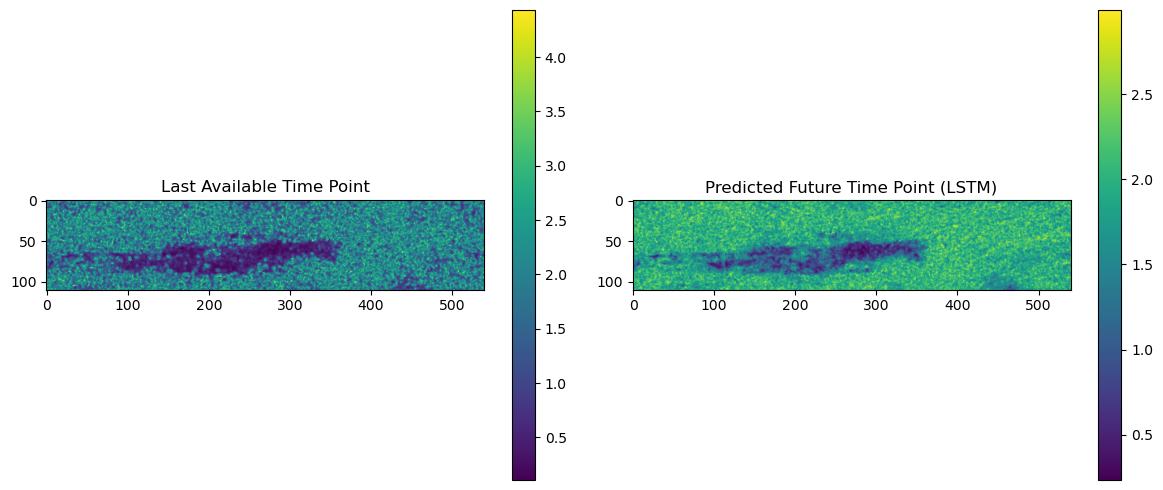

Prediction results saved successfully!


In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import datetime
import matplotlib.pyplot as plt
import logging
from sklearn.preprocessing import MinMaxScaler
import pickle
import os

# Suppress Matplotlib debug messages
logging.getLogger('matplotlib').setLevel(logging.WARNING)
# ============================================================
# 1. Import Libraries
# ============================================================

# ============================================================
# 2. Dataset Definition
# ============================================================
class InSARDataset(Dataset):
    """
    Custom dataset for InSAR time series.

    Args:
        data (numpy.ndarray): InSAR timeseries, shape (H, W, T).
        dates (list[str]): List of interferogram intervals, e.g. ["20150815_20150827", ...].
        window_size (int): Temporal window size. Default: 20.
        is_prediction (bool): If True, builds dataset for forecasting the next step.
    """
    def __init__(self, data, dates, window_size=20, is_prediction=False):
        self.data = data
        self.height, self.width, self.time_steps = data.shape
        self.window_size = window_size
        self.is_prediction = is_prediction

        # ---- Extract temporal features ----
        self.time_features = []
        for date_str in dates:
            start_date, end_date = date_str.split('_')
            start = datetime.datetime.strptime(start_date, '%Y%m%d')
            end = datetime.datetime.strptime(end_date, '%Y%m%d')

            year_sin = np.sin(2 * np.pi * start.year / 2100)
            year_cos = np.cos(2 * np.pi * start.year / 2100)
            month_sin = np.sin(2 * np.pi * start.month / 12)
            month_cos = np.cos(2 * np.pi * start.month / 12)
            day_sin = np.sin(2 * np.pi * start.day / 31)
            day_cos = np.cos(2 * np.pi * start.day / 31)
            interval = (end - start).days

            self.time_features.append([year_sin, year_cos, month_sin, month_cos,
                                       day_sin, day_cos, interval])
        self.time_features = np.array(self.time_features)

        # ---- Normalize each pixel individually ----
        self.scalers = {}
        self.scaled_data = np.zeros_like(self.data, dtype=np.float32)

        for i in range(self.height):
            for j in range(self.width):
                pixel_ts = self.data[i, j, :]
                scaler = MinMaxScaler(feature_range=(-1, 1))
                self.scaled_data[i, j, :] = scaler.fit_transform(pixel_ts.reshape(-1, 1)).flatten()
                self.scalers[(i, j)] = scaler

        # ---- Build sample indices ----
        self.samples = [(i, j) for i in range(self.height) for j in range(self.width)]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        i, j = self.samples[idx]
        pixel_ts = self.scaled_data[i, j, :]

        if not self.is_prediction:  # Training
            x = pixel_ts[:-1]  # first T-1 steps
            y = pixel_ts[-1]   # last step
            time_feat = self.time_features[:-1]
            target_time_feat = self.time_features[-1]
        else:  # Prediction
            x = pixel_ts
            y = 0.0  # placeholder
            time_feat = self.time_features[:self.time_steps]
            target_time_feat = self.time_features[-1]

        return {
            'pixel_coords': torch.tensor([i, j]),
            'x': torch.tensor(x, dtype=torch.float32),
            'time_features': torch.tensor(time_feat, dtype=torch.float32),
            'target_time_features': torch.tensor(target_time_feat, dtype=torch.float32),
            'y': torch.tensor(y, dtype=torch.float32)
        }

# ============================================================
# 3. LSTM Model
# ============================================================
class InSARLSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, dropout=0.1, time_feat_dim=7):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.input_embedding = nn.Linear(input_dim, hidden_dim)
        self.time_embedding = nn.Linear(time_feat_dim, hidden_dim)

        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.target_time_proj = nn.Linear(time_feat_dim, hidden_dim)

        self.output_layer = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, src, time_features, target_time_features):
        batch_size = src.size(0)
        src = src.unsqueeze(-1)  # [B, T, 1]
        src = self.input_embedding(src)  # [B, T, H]
        time_embed = self.time_embedding(time_features)  # [B, T, H]

        combined_input = src + time_embed
        lstm_out, (h_n, c_n) = self.lstm(combined_input)
        seq_repr = h_n[-1]  # last hidden state

        target_time_embed = self.target_time_proj(target_time_features)
        combined = torch.cat([seq_repr, target_time_embed], dim=-1)

        output = self.output_layer(combined)
        return output.squeeze(-1)

# ============================================================
# 4. Training and Prediction Utilities
# ============================================================
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, device='cuda'):
    model.to(device)
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            x = batch['x'].to(device)
            time_features = batch['time_features'].to(device)
            target_time_features = batch['target_time_features'].to(device)
            y = batch['y'].to(device)

            optimizer.zero_grad()
            outputs = model(x, time_features, target_time_features)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x.size(0)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                x = batch['x'].to(device)
                time_features = batch['time_features'].to(device)
                target_time_features = batch['target_time_features'].to(device)
                y = batch['y'].to(device)

                outputs = model(x, time_features, target_time_features)
                loss = criterion(outputs, y)
                val_loss += loss.item() * x.size(0)
        val_loss /= len(val_loader.dataset)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

    return model


def predict_future(model, dataset, device='cuda'):
    model.eval()
    predictions = np.zeros((dataset.height, dataset.width))
    dataloader = DataLoader(dataset, batch_size=256, shuffle=False)

    with torch.no_grad():
        for batch in dataloader:
            coords = batch['pixel_coords'].numpy()
            x = batch['x'].to(device)
            time_features = batch['time_features'].to(device)
            target_time_features = batch['target_time_features'].to(device)

            outputs = model(x, time_features, target_time_features)
            for i in range(len(coords)):
                pixel_i, pixel_j = coords[i]
                scaler = dataset.scalers[(pixel_i, pixel_j)]
                predictions[pixel_i, pixel_j] = scaler.inverse_transform(
                    outputs[i].cpu().numpy().reshape(-1, 1))[0, 0]

    return predictions

# ============================================================
# 5. Save Prediction Results
# ============================================================
def save_predict_results(predictions, model, output_path):
    os.makedirs(output_path, exist_ok=True)

    # Save predictions
    predict_data_path = os.path.join(output_path, "future_predictions.npy")
    np.save(predict_data_path, predictions)
    print(f"Prediction results saved to: {predict_data_path}")

    # Save the trained model
    model_path = os.path.join(output_path, "best_model.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Trained model saved to: {model_path}")

# ============================================================
# 6. Example Usage
# ============================================================

# ---- Device ----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================================
# Load Data and Dates
# ============================================================

# ---- Data ----
data_path = "/data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/dataset/data_std.npy"   # <-- replace with your file path
data = np.load(data_path)
print(f"Data shape: {data.shape}")   # should be (H, W, T)

# ---- Load Dates from Pickle ----
with open('/data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/dataset/dates.pkl', 'rb') as f:
    dates = pickle.load(f)

print(f"Loaded dates: {dates}")

# ---- Dataset ----
full_dataset = InSARDataset(data, dates)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# ---- Model ----
model = InSARLSTM(input_dim=1, hidden_dim=64, num_layers=2, dropout=0.1, time_feat_dim=7)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ---- Train ----
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15, device=device)

# ---- Load Best Model ----
model.load_state_dict(torch.load('best_model.pth'))

# ---- Predict ----
next_date = "20160821_20160902"
all_dates = dates + [next_date]
predict_dataset = InSARDataset(data, all_dates, is_prediction=True)

future_predictions = predict_future(model, predict_dataset, device)

# ---- Save the Prediction Results ----
predict_output_subfolder = os.path.join(output_dir, "predict")
save_predict_results(future_predictions, model, predict_output_subfolder)

# ---- Visualization ----
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(data[:, :, -1], cmap='viridis')
plt.colorbar()
plt.title('Last Available Time Point')

plt.subplot(1, 2, 2)
plt.imshow(future_predictions, cmap='viridis')
plt.colorbar()
plt.title('Predicted Future Time Point (LSTM)')

plt.tight_layout()
plt.savefig('prediction.png')
plt.show()

print("Prediction results saved successfully!")


# Normalized Difference Score Calculation for InSAR Data

This script computes the normalized difference score between two InSAR datasets: `geninue_std` (standard deviation of post-earthquake data) and `future_predictions` (predicted post-earthquake values). The calculation is performed using a block-wise approach to reduce memory usage when dealing with large data arrays. The resulting difference map is saved and visualized for further analysis.

## Key Features

1. **Normalized Difference Calculation**:

   * The script calculates the normalized difference between the two input datasets (`geninue_std` and `future_predictions`), which helps assess the changes or discrepancies between the observed and predicted post-earthquake values.

2. **Block-wise Processing**:

   * To manage large data, the difference is calculated in smaller chunks. This method ensures that memory usage remains manageable even when working with large interferogram data.

3. **Data Loading**:

   * The script loads the `geninue_std.npy` (standard deviation of post-earthquake InSAR data) and `future_predictions.npy` (predicted post-earthquake data) from specified file paths.

4. **Masking**:

   * Invalid pixels (NaN or zero values) are masked and excluded from the calculation, ensuring that these values do not affect the final score.

5. **Saving Results**:

   * The calculated difference score is saved as `score.npy`, which can be used for further analysis.

6. **Visualization**:

   * The script generates a visualization of the following three maps:

     * **Geninue Co-Disaster Value (Standard Deviation)**
     * **Predicted Co-Disaster Value**
     * **Normalized Difference Score**

## Workflow Overview

1. **Input Data**:

   * The input data consists of two files:

     * `geninue_std.npy`: Standard deviation of post-earthquake InSAR data.
     * `future_predictions.npy`: Predicted post-earthquake values.

2. **Processing**:

   * The script computes the normalized difference between the two datasets, creating a difference map for analysis.

3. **Output**:

   * The computed difference map is saved as `score.npy`.
   * The script also visualizes the geninue standard deviation, predicted values, and the normalized difference score.

## Example Directory Structure

```
/data6/WORKDIR/AmatriceSenDT22/
├── merged/
│   ├── interferograms/
│   │   ├── cropped/
│   │   │   ├── dataset/
│   │   │   └── predict/
│   │   └── ...
│   ├── interferograms/cropped/predict/
│   ├── interferograms/cropped/predict/score.npy  # Output file
```



Loaded geninue_std with shape (110, 540)
Loaded future_predictions with shape (110, 540)
Score map computed successfully.
Result saved as score.npy


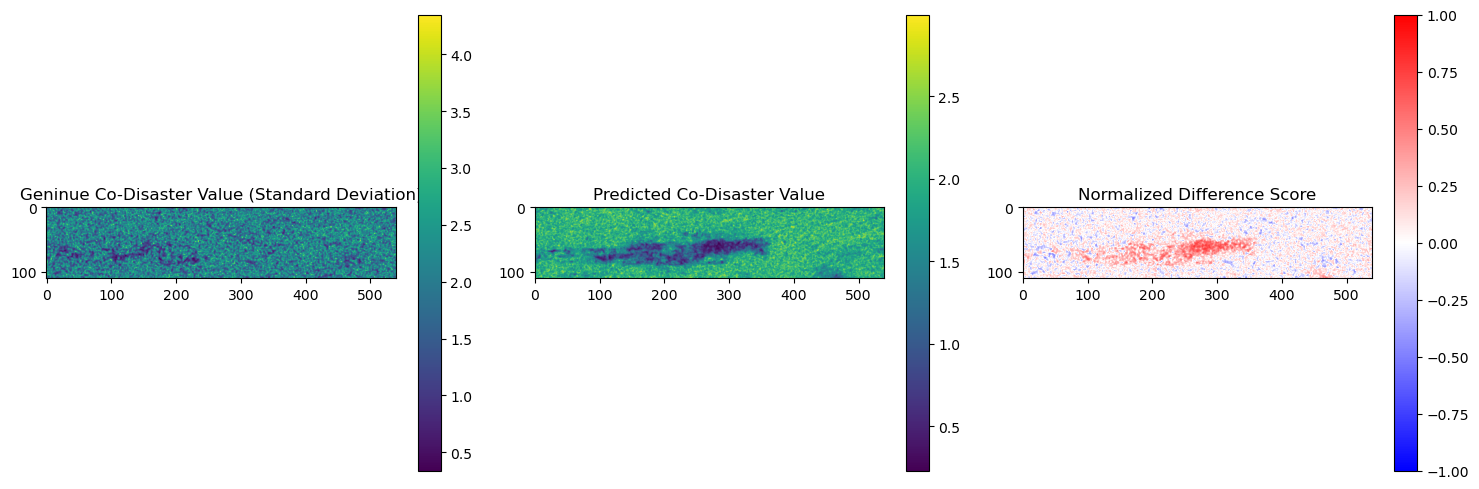

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os

# ============================================================
# 1. Function: Normalized Difference Calculation
# ============================================================
def calculate_difference(interferogram1, interferogram2, chunk_size=1024):
    """
    Compute the normalized difference between two interferograms
    with block-wise processing to reduce memory usage.
    
    Args:
        interferogram1 (np.ndarray): First interferogram (2D array).
        interferogram2 (np.ndarray): Second interferogram (2D array).
        chunk_size (int): Block size for processing to avoid memory overflow.
        
    Returns:
        np.ndarray: Difference map (float32), with NaN for invalid pixels.
    """
    if interferogram1.shape != interferogram2.shape:
        raise ValueError("Both interferograms must have the same shape.")
    
    rows, cols = interferogram1.shape
    difference = np.zeros((rows, cols), dtype=np.float32)

    chunk_rows = max(1, min(chunk_size, rows))
    chunk_cols = max(1, min(chunk_size, cols))

    for i in range(0, rows, chunk_rows):
        for j in range(0, cols, chunk_cols):
            end_i = min(i + chunk_rows, rows)
            end_j = min(j + chunk_cols, cols)

            if end_i <= i or end_j <= j:
                continue

            chunk1 = interferogram1[i:end_i, j:end_j]
            chunk2 = interferogram2[i:end_i, j:end_j]

            epsilon = 1e-8
            denominator = chunk1 + chunk2 + epsilon
            valid_mask = denominator != 0

            diff_chunk = np.full_like(chunk1, np.nan, dtype=np.float32)
            diff_chunk[valid_mask] = (chunk1[valid_mask] - chunk2[valid_mask]) / denominator[valid_mask]

            difference[i:end_i, j:end_j] = diff_chunk

    mask = np.isnan(interferogram1) | np.isnan(interferogram2) | (interferogram1 == 0) | (interferogram2 == 0)
    difference[mask] = np.nan

    return difference


# ============================================================
# 2. Load Data
# ============================================================
# Load the geninue_std.npy (geninue's standard deviation) and future_predictions.npy (predicted results)
geninue_std_path = "/data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/dataset/geninue_std.npy"
future_predictions_path = "/data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/future_predictions.npy"

geninue_std = np.load(geninue_std_path)
future_predictions = np.load(future_predictions_path)

# Option 1: Convert geninue_std to 2D (if necessary)
geninue_std = np.squeeze(geninue_std, axis=-1)

# Option 2: Alternatively, you can expand future_predictions to 3D (if necessary)
# future_predictions = np.expand_dims(future_predictions, axis=-1)

print(f"Loaded geninue_std with shape {geninue_std.shape}")
print(f"Loaded future_predictions with shape {future_predictions.shape}")

# ============================================================
# 3. Compute Normalized Difference Score
# ============================================================
# Compute the normalized difference between geninue_std and future_predictions
phase_score = calculate_difference(geninue_std, future_predictions, chunk_size=512)

# Apply masking for NaN/zeros
phase_score = np.where(np.isnan(geninue_std), np.nan,
                       np.where(geninue_std == 0, 0, phase_score))
phase_score = np.where(np.isnan(future_predictions), np.nan,
                       np.where(future_predictions == 0, 0, phase_score))

print("Score map computed successfully.")

# ============================================================
# 4. Save Results
# ============================================================
# Define output file path
output_filename = "score.npy"
output_dir = "/data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, output_filename)

# Save the score to a .npy file
np.save(output_path, phase_score)
print(f"Result saved as {output_filename}")

# ============================================================
# 5. Visualization Example
# ============================================================
# Visualization of the results
plt.figure(figsize=(15, 5))

# Geninue Co-Disaster Value (Standard Deviation)
plt.subplot(1, 3, 1)
plt.imshow(geninue_std, cmap='viridis')
plt.title("Geninue Co-Disaster Value (Standard Deviation)")
plt.colorbar()

# Predicted Co-Disaster Value (Predictions)
plt.subplot(1, 3, 2)
plt.imshow(future_predictions, cmap='viridis')
plt.title("Predicted Co-Disaster Value")
plt.colorbar()

# Normalized Difference Score
plt.subplot(1, 3, 3)
plt.imshow(phase_score, cmap="bwr", vmin=-1, vmax=1)
plt.title("Normalized Difference Score")
plt.colorbar()

plt.tight_layout()
plt.show()


# InSAR Score Processing and Geocoding

This script processes the normalized difference score files (`score.npy`) generated in the previous steps, converting them into ISCE2-compatible `.cor` files, performing geocoding, extracting subsets, and saving the results as GeoTIFF files. The workflow involves multiple steps to handle each score file and prepare it for further analysis or visualization.

## Key Features

1. **Loading and Writing ISCE2 Files**:

   * The script loads each `score.npy` file and converts it into an ISCE2-compatible `.cor` file using the `write_isce_file` function from the `mintpy` library.

2. **Geocoding**:

   * After creating the `.cor` file, the script uses the `geocode.py` tool to geocode the interferogram, associating it with corresponding latitude and longitude data.

3. **Subset Extraction**:

   * A geographic subset is extracted from the geocoded interferogram using the `subset.py` tool. The subset is defined by specific latitude and longitude boundaries.

4. **Saving as GeoTIFF**:

   * The subsetted data is saved as a GeoTIFF file using the `save_gdal.py` tool, making the data ready for use in GIS applications.

5. **Error Handling**:

   * The script includes error handling to ensure that if a file cannot be processed, the process continues for the remaining files.

## Workflow Overview

1. **Input Data**:

   * `score.npy`: The normalized difference score files, which are the result of comparing observed and predicted post-earthquake InSAR data.
   * `lat_cropped.rdr` and `lon_cropped.rdr`: The cropped latitude and longitude files for geocoding.

2. **Processing**:

   * For each `score.npy` file:

     * Convert it to ISCE2 `.cor` format.
     * Perform geocoding to associate it with the correct geographic coordinates.
     * Extract a subset of the data based on specified latitude and longitude boundaries.
     * Save the resulting subset as a GeoTIFF file.

3. **Output**:

   * The final output is a set of processed GeoTIFF files, each corresponding to a `score.npy` file.




In [6]:
import numpy as np
import os
import subprocess
from mintpy.utils.writefile import write_isce_file

# Base directory path
base_dir = "/data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict"

# Get all _score.npy files
score_files = [f for f in os.listdir(base_dir) 
              if f.endswith("score.npy") and os.path.isfile(os.path.join(base_dir, f))]

# Latitude and longitude file paths (modify to lat_cropped.rdr and lon_cropped.rdr from the parent directory)
lat_file = os.path.join(os.path.dirname(base_dir), "lat_cropped.rdr")
lon_file = os.path.join(os.path.dirname(base_dir), "lon_cropped.rdr")

# Subset extraction parameters
subset_params = "-l 42.625 42.635 -L 13.28 13.30"

# Loop through each score file
for score_file in score_files:
    try:
        # 1. Load npy data
        file_path = os.path.join(base_dir, score_file)
        print(f"Processing file: {score_file}")
        data = np.load(file_path)
        
        # 2. Create output file name base
        base_name = score_file.replace("score.npy", "")
        
        # 3. Write to ISCE format
        cor_file = os.path.join(base_dir, f"{base_name}.cor")
        write_isce_file(
            data=data,
            out_file=cor_file,
            file_type='isce_cor'
        )
        print(f"  ISCE file created: {cor_file}")
        
        # 4. Geocode the file
        geo_cor_file = os.path.join(base_dir, f"geo_{base_name}.cor")
        geocode_cmd = f"geocode.py {cor_file} --lat-file {lat_file} --lon-file {lon_file} --outdir {base_dir}"
        subprocess.run(geocode_cmd, shell=True, check=True)
        print(f"  Geocoding completed: {geo_cor_file}")
        
        # 5. Subset extraction
        subset_cor_file = os.path.join(base_dir, f"{base_name}final.cor")
        subset_cmd = f"subset.py {geo_cor_file} {subset_params} --output {subset_cor_file}"
        subprocess.run(subset_cmd, shell=True, check=True)
        print(f"  Subset extraction completed: {subset_cor_file}")
        
        # 6. Save as GeoTIFF
        tif_file = os.path.join(base_dir, f"{base_name}final.tif")
        gdal_cmd = f"save_gdal.py {subset_cor_file} --output {tif_file}"
        subprocess.run(gdal_cmd, shell=True, check=True)
        print(f"  GeoTIFF generated: {tif_file}")
        
        print(f"File {score_file} processed successfully!\n")
    
    except Exception as e:
        print(f"Error processing file {score_file}: {str(e)}")
        continue

print("All files processed successfully!")


Processing file: score.npy
write file: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/.cor
write file: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/.cor.xml
write file: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/.cor.vrt
  ISCE file created: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/.cor


number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/lat_cropped.rdr
calculate output pixel size using approach 1 (same pixel area before/after resampling)
calculate output pixel size using approach 2 (same matrix shape before/after resampling)
output pixel size in (lat, lon) in degree: (-0.00014761828501290138, 4.800396637925411e-05)
output area extent in (S, N, W, E) in degree: (42.62151966619929, 42.63775767755071, 13.276840049835657, 13.302762191680454)
output file row / column number: (110, 540)
[1/1] preparing geometry for dest_box: (0, 0, 540, 110) --> full src_box: (0, 0, 540, 110)
--------------------------------------------------
resampling file: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/.cor
--------------------------------------------------1/1
reading band1 in block (0, 0, 540, 110) from .cor ...
nearest resampling with pyres

/home/yangyc/.conda/envs/isce_env/lib/python3.8/site-packages/mintpy/save_gdal.py:57: UserWarning: No EPSG or UTM_ZONE metadata found! Assume EPSG = 4326 (WGS84) and continue.
  warnings.warn(msg)


2025-12-03 12:54:43,633 - fiona._env - DEBUG - GDAL_DATA found in environment.
2025-12-03 12:54:43,635 - fiona._env - DEBUG - PROJ_DATA found in environment.
run view.py in MintPy version 1.6.1, date 2024-07-31
input file is isce .cor file: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/geo_.cor in float32 format
file size in y/x: (110, 540)
num of datasets in file geo_.cor: 1
datasets to exclude (0):
[]
datasets to display (1):
['band1']
data   coverage in y/x: (0, 0, 540, 110)
subset coverage in y/x: (0, 0, 540, 110)
data   coverage in lat/lon: (13.276840049835657, 42.63775767755071, 13.302762191680454, 42.62151966619929)
subset coverage in lat/lon: (13.276840049835657, 42.63775767755071, 13.302762191680454, 42.62151966619929)
------------------------------------------------------------------------
colormap: gray
figure title: geo_.cor
figure size : [10.0, 5.0]
reading data ...
data    range: [-0.5929633, 0.8276505] 1
display range: [0.0, 1.0] 1
display data in 

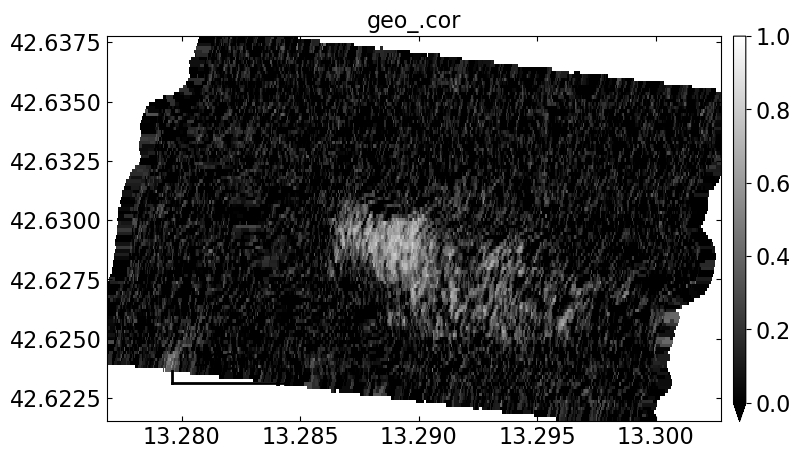

run view.py in MintPy version 1.6.1, date 2024-07-31
input file is gdal .tif file: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/final.tif in float32 format
file size in y/x: (68, 417)
num of datasets in file final.tif: 1
datasets to exclude (0):
[]
datasets to display (1):
['band1']
data   coverage in y/x: (0, 0, 417, 68)
subset coverage in y/x: (0, 0, 417, 68)
data   coverage in lat/lon: (13.27996030765031, 42.635100548420475, 13.299977961630457, 42.625062505039594)
subset coverage in lat/lon: (13.27996030765031, 42.635100548420475, 13.299977961630457, 42.625062505039594)
------------------------------------------------------------------------
colormap: jet
figure title: final.tif
figure size : [10.0, 4.0]
reading data ...
data    range: [-0.5929633, 0.8276505] 1
display range: [-0.5929633, 0.8276505] 1
display data in transparency: 1.0
plot in geo-coordinate
plotting data as image via matplotlib.pyplot.imshow ...
plot scale bar: [0.2, 0.2, 0.1]
showing ...


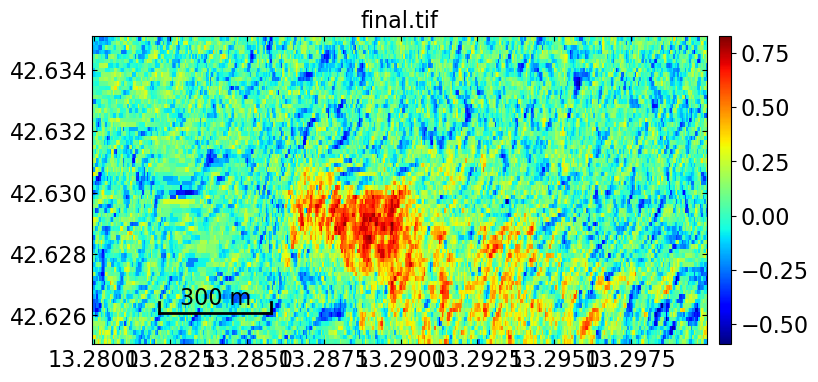

In [7]:
from mintpy.cli import view
view.main('/data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/geo_.cor'.split())
view.main('/data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/final.tif'.split())